<a href="https://colab.research.google.com/github/SirNavalot/BiostatisticsMPCR/blob/main/Shaurnav_Ghosh_Biostatistics_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#If training is slow try restarting the notebook and re-run the code

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-l2u7p5tw
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-l2u7p5tw
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=5914 sha256=f606bc2248ccf9a302ef54eeb76a1a77264a7db2e9f78cc808805e6620633101
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8dmr6hc/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [ ]:
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=fff35bea0935e6a7df319a1cc9bcb4b9b37ee61a71473898a367ae22ab7f4ae5
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch


In [ ]:
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [ ]:
os.chdir('/content/drive/My Drive/Biostatistics Labs/Lab 5/Data1/flowers102/')

In [ ]:
#This code will download the dataset
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flower_data/train/7/image_07232.jpg  
  inflating: flower_data/train/7/image_08101.jpg  
  inflating: flower_data/train/7/image_07226.jpg  
  inflating: flower_data/train/7/image_07227.jpg  
  inflating: flower_data/train/7/image_08100.jpg  
  inflating: flower_data/train/7/image_07233.jpg  
   creating: flower_data/train/29/
  inflating: flower_data/train/29/image_04152.jpg  
  inflating: flower_data/train/29/image_04147.jpg  
  inflating: flower_data/train/29/image_04153.jpg  
  inflating: flower_data/train/29/image_04151.jpg  
  inflating: flower_data/train/29/image_04150.jpg  
  inflating: flower_data/train/29/image_04144.jpg  
  inflating: flower_data/train/29/image_04140.jpg  
  inflating: flower_data/train/29/image_04154.jpg  
  inflating: flower_data/train/29/image_04155.jpg  
  inflating: flower_data/train/29/image_04141.jpg  
  inflating: flower_data/train/29/image_04157.jpg  
  inflating: flower_data/train/29/im

In [ ]:
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt',header=None)[0]

In [ ]:
data_dir = '/content/drive/My Drive/Biostatistics Labs/Lab 5/Data1/flowers102/flower_data/'

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [ ]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

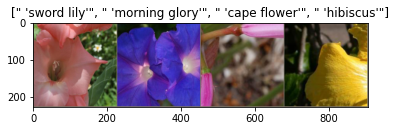

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[int(class_names[x])-1] for x in classes])

In [ ]:
from barbar import Bar

In [ ]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model = train_model(model, num_epochs=3)

Epoch:  1 / 3
6552/6552: [===============================>] - ETA 0.7s
Train  Acc: 0.41
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.78
#######################
Epoch:  2 / 3
6552/6552: [===============================>] - ETA 0.7s
Train  Acc: 0.77
818/818: [===============================>] - ETA 0.4s
Valid  Acc: 0.92
#######################
Epoch:  3 / 3
6552/6552: [===============================>] - ETA 0.5s
Train  Acc: 0.85
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.95
#######################


In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[int(class_names[preds[j]])-1] + '     class: ' + dataset_labels[int(class_names[labels[j]])-1]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

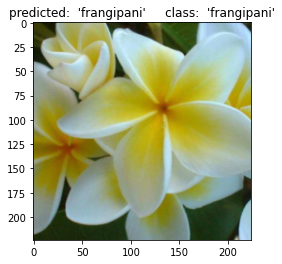

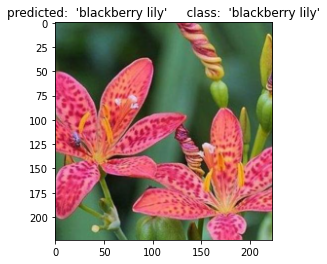

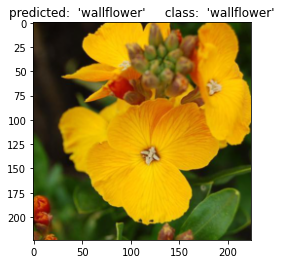

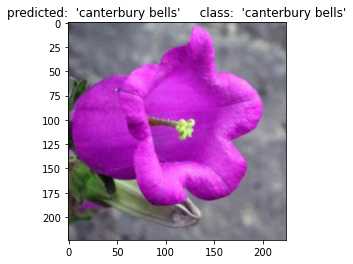

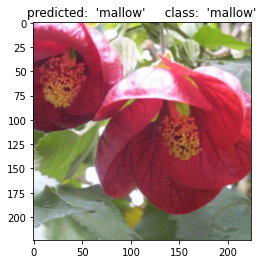

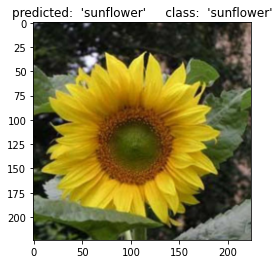

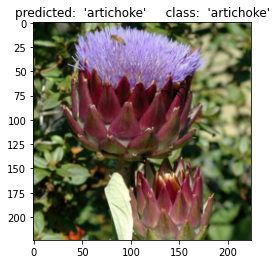

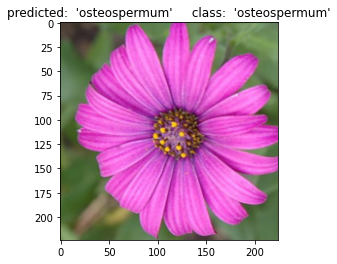

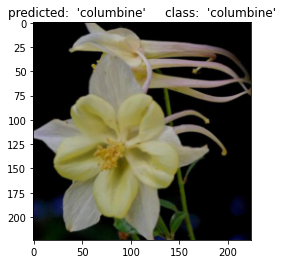

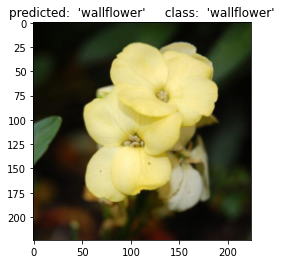

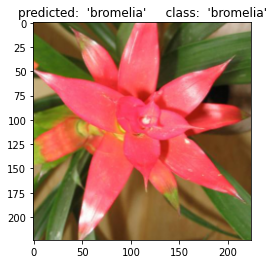

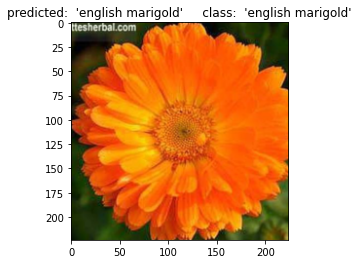

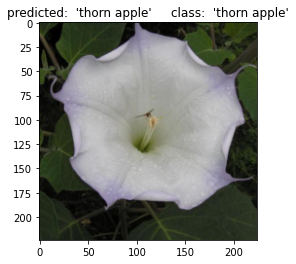

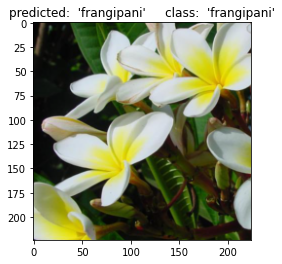

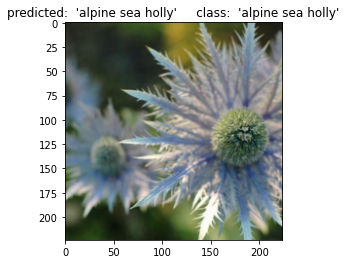

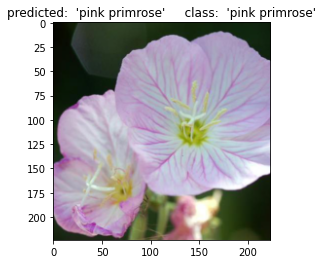

In [ ]:
visualize_model(model)

(395, 500, 3)


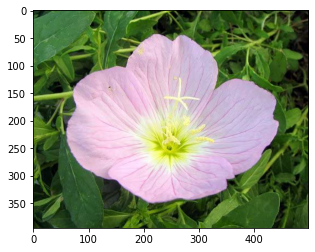

In [ ]:
image = io.imread('https://images-na.ssl-images-amazon.com/images/I/51dZp-%2B4W9L._AC_.jpg')
plt.imshow(image);
print(np.shape(image));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


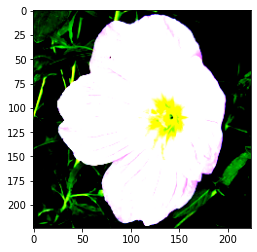

In [ ]:
#Transformation...
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)
imagenew = apply_transforms(image).detach().numpy()[0, :, :, :]
imagenew = imagenew.swapaxes(0, 2)
plt.imshow(imagenew)

In [ ]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [ ]:
print('predicted: ' + dataset_labels[int(class_names[preds])-1])


predicted:  'pink primrose'


tensor([[ 8.9515, -1.3276, -1.6046, -0.8145, -1.3863, -2.8263,  0.9870,  1.2486,
          0.8480, -1.4534, -0.6880,  0.4631,  0.0353,  4.9960, -0.6476, -0.1330,
         -2.1435,  0.3149,  0.0157, -1.9213, -1.3996, -0.2563, -2.7907, -1.1456,
         -0.4948, -0.2251, -0.9536, -0.8703,  1.1899,  0.6577,  5.4573, -2.3455,
         -1.5115, -1.0388,  0.8570,  0.1814, -1.8579, -0.1654, -0.2524, -0.8629,
         -1.6045,  0.2063,  0.9038, -1.0347, -1.8095, -0.4811,  1.3990, -0.2022,
         -1.4118,  2.6356,  1.3134,  1.4537, -1.3134,  4.4989, -1.3055, -0.0858,
         -1.5372, -1.5176, -2.6473, -0.4037, -2.1599,  0.8095, -2.2614,  4.9452,
          3.2355,  3.0891,  3.7010,  0.5965,  3.7709, -1.4620,  0.2942, -3.1226,
         -1.1051,  0.2303, -2.3146,  0.5071,  3.4375,  2.0887,  0.1836, -0.8089,
         -2.2995,  1.2488, -2.0121,  0.3529,  3.1886, -0.6064, -4.0077,  7.0975,
         -1.9268, -1.5135,  1.3743, -2.3898, -2.4885,  1.6160, -0.3416,  2.0055,
         -2.6736,  0.5664, -